<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Adversarial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Advisorial Attacks: MNIST datasets

The reference 1 is a great tutorial, but I fixed some codes issues. All credits belong to Drs. Zico Kolter and Aleksander Madry.

Reference 
[1] https://adversarial-ml-tutorial.org/linear_models/



In [2]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [15]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006475	0.015218	0.000473	0.003125
0.001421	0.005450	0.000473	0.002528
0.001263	0.004409	0.000473	0.002471
0.001263	0.003887	0.000473	0.002255
0.000947	0.003505	0.000946	0.002104
0.000790	0.003251	0.000946	0.002058
0.000869	0.003028	0.000473	0.002000
0.000790	0.002748	0.000946	0.002016
0.000869	0.002612	0.000473	0.001955
0.000711	0.002559	0.000946	0.001860


Text(0.5, 1.0, 'True Label: 0')

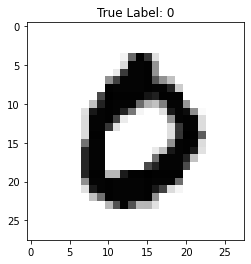

In [16]:
import matplotlib.pyplot as plt
X_test = (test_loader.dataset.data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.targets
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 0)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx][0].item()))

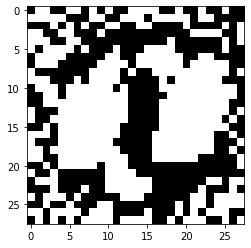

In [17]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [18]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.826950354609929, 3.3141840535698206)


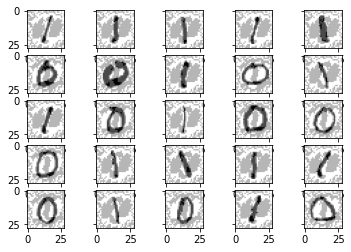

In [19]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

In [21]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [28]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.148993	0.377032	0.066194	0.216082
0.073273	0.223540	0.052009	0.172562
0.063403	0.197446	0.046336	0.158474
0.057797	0.183942	0.039716	0.143652
0.053060	0.175014	0.041135	0.141385
0.049980	0.168143	0.039716	0.139192
0.047927	0.162774	0.034988	0.127436
0.045559	0.158399	0.033570	0.124005
0.044611	0.154813	0.032624	0.120595
0.042400	0.151702	0.026950	0.113945
0.041611	0.149122	0.028842	0.115198
0.040189	0.146920	0.026950	0.108185
0.039400	0.145114	0.027423	0.109180
0.038137	0.143385	0.026005	0.105907
0.037584	0.141622	0.027423	0.110612
0.036873	0.140384	0.026478	0.112031
0.035847	0.139211	0.025532	0.107007
0.035294	0.138146	0.025532	0.102841
0.034505	0.137040	0.024586	0.102109
0.034426	0.136182	0.024586	0.101808


In [29]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006001	0.015206	0.003783	0.008203


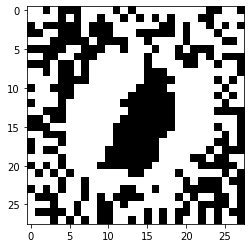

In [30]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")